In [2]:
#@title
# import required libraries

import pandas as pd # dataframes
import numpy as np #mathematical operations

# to visualise

import plotly.express as px # plotly
from wordcloud import WordCloud # wordclouds
import matplotlib.pyplot as plt #matplot
import seaborn as sns #seaborn
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer


# Vectorisation

from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

# Treating class imbalanced data

from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

# model building

from sklearn.model_selection import train_test_split

# algorithms

from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

# checking up with models

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
# confusion matrix
from sklearn import metrics
from sklearn.metrics import confusion_matrix

In [1]:
# landing google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# load your dataframe
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Research/Method 2 - Titles/preprocessed_title_OVR.csv",index_col=[0])

In [4]:
# change both types into string
df['Title'] = df['Title'].astype('str')
df['Intervention Area'] = df['Intervention Area'].astype('str') 

In [5]:
# Replace DigitalServices value with 1
df.loc[df["Intervention Area"] == "Policy & Regulation or Digital Services", "Intervention Area"] = 1
df.head(5)

,Title,Intervention Area
0,aarogya setu mobile application monitor mitiga...,Digital Information Services
1,online teach ict post covid,1
2,best method family plan text mining analysis m...,Digital Information Services
3,mobile industry impact sustainable goal,Digital Infrastructure Development
4,recommendation governance guide lawmaker regul...,Cybersecurity


In [6]:
# Replace other values with 0
df.loc[df["Intervention Area"] != 1, "Intervention Area"] = 0

# reorder the dataframe to get DigitalInfrastructure content to appear first
df = df.sort_values(by='Intervention Area', ascending=False)

df.head(5)

,Title,Intervention Area
214,covid ecommerce global review,1
1254,technology document violation enable sexworker...,1
740,inequality gender inclusion minimum ict policy...,1
605,fuel trade mercosur regulatory roadmap,1
86,evaluation impact ict socioeconomic growth,1


In [7]:
# check if there are duplicates
df.duplicated(subset=['Title']).any() #duplicates

True

In [8]:
# remove duplicates, leaving the first record
df = df.drop_duplicates(subset=['Title'],keep="first")

In [9]:
# spread of text files after removing duplicates
# Count the number of items per group
group_counts = df.groupby("Intervention Area").count()
group_counts=group_counts.reset_index()

# Create the bar chart
fig = px.bar(group_counts, x='Intervention Area', y='Title',color="Intervention Area")

# Show the chart
fig.show()

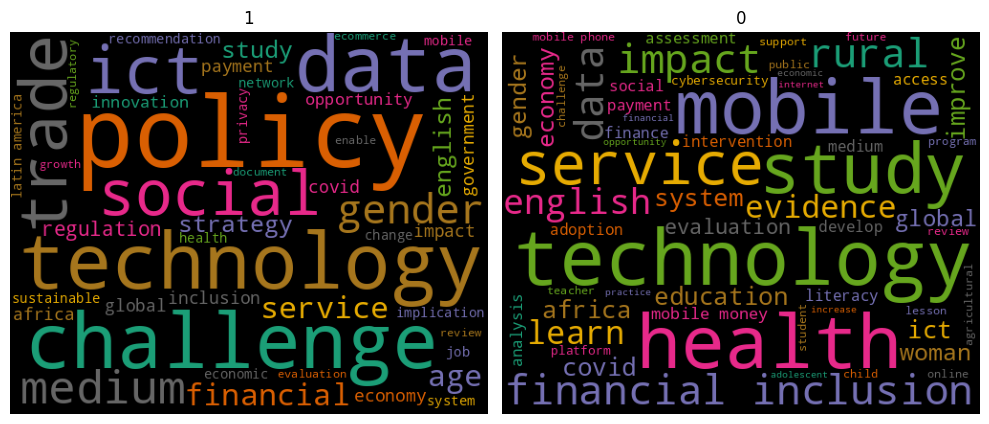

In [11]:
# word clouds based on intervention areas

# Get all the unique classes in the dataset
classes = df['Intervention Area'].unique()

# Create a figure with 4 subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 10))
axs = axs.ravel()

# Iterate through each class
for i, class_name in enumerate(classes):
    # Get all the text for the current class
    class_text = df[df['Intervention Area'] == class_name]['Title'].str.cat(sep=' ')
    # Generate the wordcloud
    wordcloud = WordCloud(width = 500, height = 400, 
                colormap="Dark2",
                min_font_size = 10).generate(class_text) 
    # Plot the wordcloud
    axs[i].imshow(wordcloud) 
    axs[i].set_title(f"{class_name}") 
    axs[i].axis("off") 
fig.tight_layout()
plt.show()

In [12]:
# Split into words
num_words = df["Title"].str.split().apply(len)

In [13]:
max(num_words)

20

In [14]:
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

In [15]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [16]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [17]:
# Filter the dataframe to include only class 0 samples
class_0_df = df[df['Intervention Area'] == 0]

# Concatenate the text data from class 0 samples into a single string
class_0_text = ' '.join(class_0_df['Title'])

# Tokenize and filter the text data from class 0 samples
class_0_tokens = nltk.word_tokenize(class_0_text)

# Count the frequency of each word in class 0
class_0_word_freq = nltk.FreqDist(class_0_tokens)

# Filter the dataframe to include only class 1 samples
class_1_df = df[df['Intervention Area'] == 1]

# Concatenate the text data from class 1 samples into a single string
class_1_text = ' '.join(class_1_df['Title'])

# Tokenize and filter the text data from class 1 samples
class_1_tokens = nltk.word_tokenize(class_1_text)


# Count the frequency of each word in class 1
class_1_word_freq = nltk.FreqDist(class_1_tokens)

# Get the keywords that are common in class 1 but not common in class 0
k = 10  # Specify the desired number of keywords
keywords = []

for word, frequency in class_1_word_freq.items():
    if word in class_0_word_freq:
        if frequency > class_0_word_freq[word]:
            keywords.append((word, frequency))

# Sort the keywords by frequency in descending order
keywords.sort(key=lambda x: x[1], reverse=True)

# Print the top keywords
for keyword, frequency in keywords[:k]:
    print(keyword, frequency)

latin 3
america 3
caribbean 2


In [18]:
# vectorsing the content column
vectorizer = TfidfVectorizer(stop_words=None, max_features=30)
vectorized_df = vectorizer.fit_transform(df['Title'])
# defining the y label
y = df['Intervention Area']
y=y.astype('int')
y=y.to_frame()

In [19]:
keywords= []

In [20]:
import numpy as np

# Create binary features for each keyword
for keyword in keywords:
    df[keyword] = np.where(df['Title'].str.contains(keyword), 1, 0)

In [21]:
from scipy.sparse import hstack

# Concatenate the binary features with the vectorized features
X = hstack([vectorized_df, df[keywords].values])

In [22]:
# train test split
X_train, x_test, Y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=75)

In [23]:
# treat class imbalanced data
ros = RandomOverSampler(random_state=42)
X_trainro, Y_trainro = ros.fit_resample(X_train, Y_train)

In [24]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=42)
X_trainru, Y_trainru = rus.fit_resample(X_train, Y_train)

Decision Tree

In [25]:
# fit the model
dt = DecisionTreeClassifier(class_weight='balanced')
dt.fit(X_train, Y_train.values.ravel())

# make predictions
pred_dt = dt.predict(x_test)

# print accuracy 
print("Accuracy %s" % accuracy_score(pred_dt,y_test))

Accuracy 0.6115702479338843


In [26]:
print(classification_report(y_test,pred_dt))

              precision    recall  f1-score   support

           0       0.93      0.62      0.74       221
           1       0.12      0.52      0.19        21

    accuracy                           0.61       242
   macro avg       0.52      0.57      0.47       242
weighted avg       0.86      0.61      0.70       242



Naive bayes

In [27]:
# fit the model
nb = MultinomialNB()
nb.fit(X_trainro, Y_trainro.values.ravel())

# make predictions 
pred_nb = nb.predict(x_test)

# print accuracy
print("Accuracy %s" % accuracy_score(pred_nb,y_test))

Accuracy 0.7107438016528925


In [28]:
print(classification_report(y_test,pred_nb))

              precision    recall  f1-score   support

           0       0.92      0.75      0.83       221
           1       0.10      0.29      0.15        21

    accuracy                           0.71       242
   macro avg       0.51      0.52      0.49       242
weighted avg       0.85      0.71      0.77       242



K-Nearest

In [29]:
# fit the model
knn = KNeighborsClassifier()
knn.fit(X_trainro, Y_trainro.values.ravel())

# make predictions
pred_knn = knn.predict(x_test)

# print accuracy
print("Accuracy %s" % accuracy_score(pred_knn,y_test))

Accuracy 0.8553719008264463


In [30]:
print(classification_report(y_test,pred_knn))

              precision    recall  f1-score   support

           0       0.92      0.93      0.92       221
           1       0.11      0.10      0.10        21

    accuracy                           0.86       242
   macro avg       0.51      0.51      0.51       242
weighted avg       0.85      0.86      0.85       242



Logistic

In [31]:
# fit the model
lr = LogisticRegression(class_weight='balanced')
lr.fit(X_train, Y_train.values.ravel())

# make predictions
pred_lr = lr.predict(x_test)

# print accuracy
print("Accuracy %s" % accuracy_score(pred_lr,y_test))

Accuracy 0.7272727272727273


In [32]:
print(classification_report(y_test,pred_lr))

              precision    recall  f1-score   support

           0       0.91      0.77      0.84       221
           1       0.09      0.24      0.13        21

    accuracy                           0.73       242
   macro avg       0.50      0.51      0.48       242
weighted avg       0.84      0.73      0.78       242



Ada boost

In [33]:
# fit the model
ab = AdaBoostClassifier()
ab.fit(X_trainro, Y_trainro.values.ravel())

# make predictions
pred_ab = ab.predict(x_test)

# print accuracy
print("Accuracy %s" % accuracy_score(pred_ab,y_test))

Accuracy 0.6074380165289256


In [34]:
print(classification_report(y_test,pred_ab))

              precision    recall  f1-score   support

           0       0.94      0.61      0.74       221
           1       0.12      0.57      0.20        21

    accuracy                           0.61       242
   macro avg       0.53      0.59      0.47       242
weighted avg       0.87      0.61      0.69       242



SGD

In [35]:
# fit the model
sgd = SGDClassifier(class_weight='balanced')
sgd.fit(X_train, Y_train.values.ravel())

# make predictions
pred_sgd = sgd.predict(x_test)

# print accuracy
print("Accuracy %s" % accuracy_score(pred_sgd,y_test))

Accuracy 0.4793388429752066


In [36]:
print(classification_report(y_test,pred_sgd))

              precision    recall  f1-score   support

           0       0.91      0.48      0.63       221
           1       0.08      0.48      0.14        21

    accuracy                           0.48       242
   macro avg       0.49      0.48      0.38       242
weighted avg       0.83      0.48      0.58       242



Support Vector

In [37]:
# fit the model
svc = SVC(class_weight='balanced')
svc.fit(X_train, Y_train.values.ravel())

# make predictions
pred_svc = svc.predict(x_test)

# print accuracy
print("Accuracy %s" % accuracy_score(pred_svc,y_test))

Accuracy 0.5826446280991735


In [38]:
print(classification_report(y_test,pred_svc))

              precision    recall  f1-score   support

           0       0.92      0.59      0.72       221
           1       0.10      0.48      0.17        21

    accuracy                           0.58       242
   macro avg       0.51      0.53      0.44       242
weighted avg       0.85      0.58      0.67       242



Logistic regression is the best model according to accuracy


In [39]:
from sklearn.ensemble import VotingClassifier

# Create instances of the SGDClassifier and RandomForestClassifier
lr = LogisticRegression()
nb = MultinomialNB()

# Create an instance of the VotingClassifier
ensemble = VotingClassifier(estimators=[('lr', lr), ('nb', nb)], voting='hard')

# Fit the VotingClassifier to the data
ensemble.fit(X_trainro, Y_trainro.values.ravel())

# Make predictions
pred_ensemble = ensemble.predict(x_test)

# Print accuracy
print("Accuracy %s" % accuracy_score(pred_ensemble, y_test))

Accuracy 0.731404958677686


In [40]:
print(classification_report(y_test,pred_ensemble))

              precision    recall  f1-score   support

           0       0.91      0.78      0.84       221
           1       0.08      0.19      0.11        21

    accuracy                           0.73       242
   macro avg       0.49      0.49      0.48       242
weighted avg       0.84      0.73      0.78       242



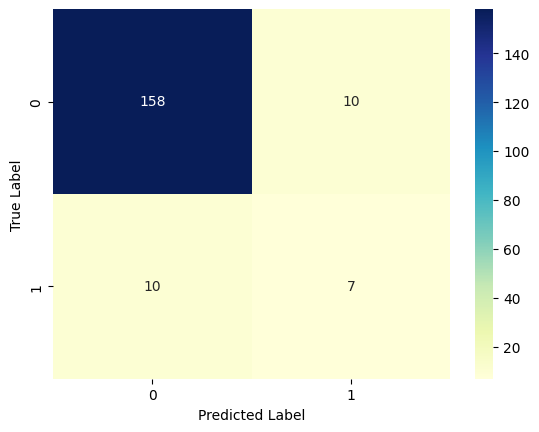

In [ ]:
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, pred_lr)

import matplotlib.pyplot as plt
import seaborn as sns

sns.heatmap(conf_matrix, annot = True, fmt = "d", cmap = "YlGnBu")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
from joblib import Parallel, delayed
import joblib

# Save the model as a pickle in a file
joblib.dump(lr, '/content/drive/MyDrive/Colab Notebooks/Research/digitalservice.pkl')

['/content/drive/MyDrive/Colab Notebooks/Research/digitalservice.pkl']